## Data

Generally, when we have to deal with image, text, audio or video data, we can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, there's a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

Here we will use the CIFAR10 dataset, which has the classes
- "airplane"
- "automobile"
- "bird"
- "cat"
- "deer"
- "frog"
- "horse"
- "ship"
- "truck"

The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src="https://pytorch.org/tutorials/_images/cifar10.png">

## Train an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data

### 1. Load and normalize CIFAR10

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

# test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show some of the training images:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

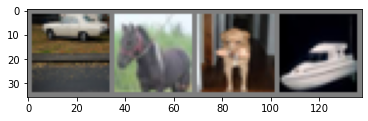

car horse dog ship


In [ ]:
# get some random training images
data_iter = iter(trainloader)
images, labels = data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f"{classes[labels[j]]}" for j in range(4)))

### 2. Define a CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # flatten
        x = x.view(-1, 16 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 3. Define loss function and optimizer

Here we will use a classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

- Simply loop over our data iterator
- Feed the inputs to the network
- Optimize

In [ ]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        # data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        outputs = net(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished training!")

[1,  2000] loss: 2.171
[1,  4000] loss: 1.871
[1,  6000] loss: 1.675
[1,  8000] loss: 1.578
[1, 10000] loss: 1.500
[1, 12000] loss: 1.472
[2,  2000] loss: 1.408
[2,  4000] loss: 1.373
[2,  6000] loss: 1.334
[2,  8000] loss: 1.306
[2, 10000] loss: 1.311
[2, 12000] loss: 1.249
Finished training!


#### Save trained model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on test data

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Firstly, let's display an image from the test set to get familiar:

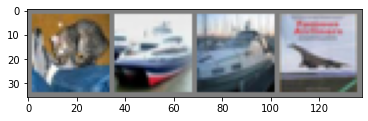

GroundTruth:    cat  ship  ship plane


In [ ]:
data_iter = iter(testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Let's see what our trained neural network thinks these examples above are:

In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. 

So, let’s get the index of the highest energy:

In [ ]:
outputs

tensor([[-0.8761, -1.2853,  0.6083,  2.0769,  0.3639,  0.5455,  1.7700, -1.4726,
          0.7162, -1.4893],
        [ 5.1342,  6.1614, -1.7875, -1.7750, -5.9078, -5.1125, -5.0593, -5.6536,
          9.8685,  3.9743],
        [ 2.6646,  2.3009,  0.2059, -1.1554, -1.7639, -2.2992, -2.5470, -2.5464,
          3.8503,  1.8075],
        [ 3.4207,  1.2680,  0.2780, -1.0378, -1.7212, -3.3135, -3.2850, -2.4699,
          4.0488,  2.0156]], grad_fn=<AddmmBackward>)

In [ ]:
_, predicted = torch.max(outputs, 1)
predicted # index of the highest energy in each output

tensor([3, 8, 8, 8])

In [ ]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results semm good!

Now let's look at how the network performs on the whole dataset:

In [ ]:
correct, total = 0, 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


Seems like the network learnt something.

Now let's see which class performed well and which did not perform well:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 64 %
Accuracy of  bird : 31 %
Accuracy of   cat : 41 %
Accuracy of  deer : 43 %
Accuracy of   dog : 51 %
Accuracy of  frog : 77 %
Accuracy of horse : 52 %
Accuracy of  ship : 75 %
Accuracy of truck : 72 %


## Train on GPU

First, define our device as the first visible cuda device if we have CUDA available:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Transfer the neural network onto the GPU

In [ ]:
# recursively go over all modules and
# convert their parameters and buffers to CUDA tensors
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# also send inputs and targets at every step to the GPU
inputs, labels = data[0].to(device), data[1].to(device)

Notice that if the network is small, using GPU won't give up a massive speedup compared to CPU.